# Time Series Analysis Crash Course for Data Science Assessments

**Last Updated:** 25 January 2026

This notebook covers time series analysis concepts commonly tested in data science interviews. We focus on understanding time series components, stationarity, forecasting models, and evaluation techniques.

## Table of Contents

1. [Introduction and Setup](#1-introduction-and-setup)
2. [Time Series Components](#2-time-series-components)
3. [Stationarity](#3-stationarity)
4. [Autocorrelation (ACF and PACF)](#4-autocorrelation-acf-and-pacf)
5. [Moving Averages and Smoothing](#5-moving-averages-and-smoothing)
6. [ARIMA Models](#6-arima-models)
7. [Seasonal ARIMA (SARIMA)](#7-seasonal-arima-sarima)
8. [Exponential Smoothing](#8-exponential-smoothing)
9. [Time Series Cross-Validation](#9-time-series-cross-validation)
10. [Forecasting Metrics](#10-forecasting-metrics)
11. [Feature Engineering for Time Series](#11-feature-engineering-for-time-series)
12. [Practice Questions](#12-practice-questions)
13. [Summary](#13-summary)

---

## 1. Introduction and Setup

**Time series** data is a sequence of observations recorded at successive time intervals. Unlike cross-sectional data, the order matters and observations are often correlated.

**Key Characteristics:**
- **Temporal ordering**: Data points have a natural sequence
- **Autocorrelation**: Past values influence future values
- **Non-exchangeability**: Cannot randomly shuffle observations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Dict, Any

from statsmodels.tsa.stattools import adfuller, kpss, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

print("All imports successful!")

All imports successful!


### Creating Sample Time Series Data

In [2]:
def create_sample_timeseries(
    n_points: int = 365,
    trend: float = 0.05,
    seasonality_period: int = 30,
    seasonality_amplitude: float = 10,
    noise_std: float = 2
) -> pd.Series:
    """Create a synthetic time series with trend, seasonality, and noise.
    
    Args:
        n_points: Number of data points.
        trend: Linear trend coefficient.
        seasonality_period: Period of seasonal component.
        seasonality_amplitude: Amplitude of seasonal component.
        noise_std: Standard deviation of random noise.
    
    Returns:
        Pandas Series with datetime index.
    """
    dates = pd.date_range(start='2024-01-01', periods=n_points, freq='D')
    t = np.arange(n_points)
    
    trend_component = 100 + trend * t
    seasonal_component = seasonality_amplitude * np.sin(2 * np.pi * t / seasonality_period)
    noise_component = np.random.normal(0, noise_std, n_points)
    
    values = trend_component + seasonal_component + noise_component
    
    return pd.Series(values, index=dates, name='value')

In [3]:
ts = create_sample_timeseries()

print(f"Time series shape: {ts.shape}")
print(f"Date range: {ts.index.min()} to {ts.index.max()}")
print(f"\nSummary statistics:")
print(ts.describe())

Time series shape: (365,)
Date range: 2024-01-01 00:00:00 to 2024-12-30 00:00:00

Summary statistics:
count    365.000000
mean     109.173196
std        8.896505
min       88.355285
25%      102.138511
50%      109.406270
75%      115.627574
max      127.671082
Name: value, dtype: float64


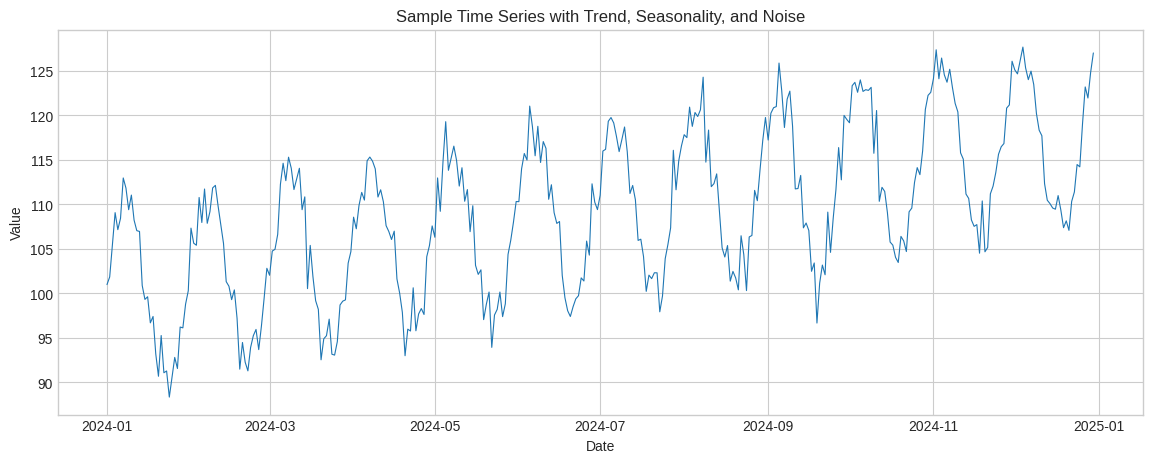

In [4]:
plt.figure(figsize=(14, 5))
plt.plot(ts.index, ts.values, linewidth=0.8)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Sample Time Series with Trend, Seasonality, and Noise')
plt.show()

---

## 2. Time Series Components

A time series can be decomposed into:

| Component | Description | Example |
|-----------|-------------|--------|
| **Trend** | Long-term increase or decrease | Population growth |
| **Seasonality** | Regular periodic patterns | Monthly sales cycles |
| **Cyclical** | Irregular long-term fluctuations | Business cycles |
| **Residual** | Random noise | Unpredictable variations |

**Decomposition Types:**
- **Additive**: $Y_t = T_t + S_t + R_t$ (constant seasonal amplitude)
- **Multiplicative**: $Y_t = T_t \times S_t \times R_t$ (seasonal amplitude proportional to level)

In [5]:
def decompose_timeseries(
    ts: pd.Series,
    model: str = 'additive',
    period: int = None
) -> Dict[str, pd.Series]:
    """Decompose time series into components.
    
    Args:
        ts: Time series data.
        model: 'additive' or 'multiplicative'.
        period: Seasonal period (auto-detected if None).
    
    Returns:
        Dictionary with trend, seasonal, and residual components.
    """
    decomposition = seasonal_decompose(ts, model=model, period=period)
    
    return {
        'trend': decomposition.trend,
        'seasonal': decomposition.seasonal,
        'residual': decomposition.resid,
        'observed': decomposition.observed
    }

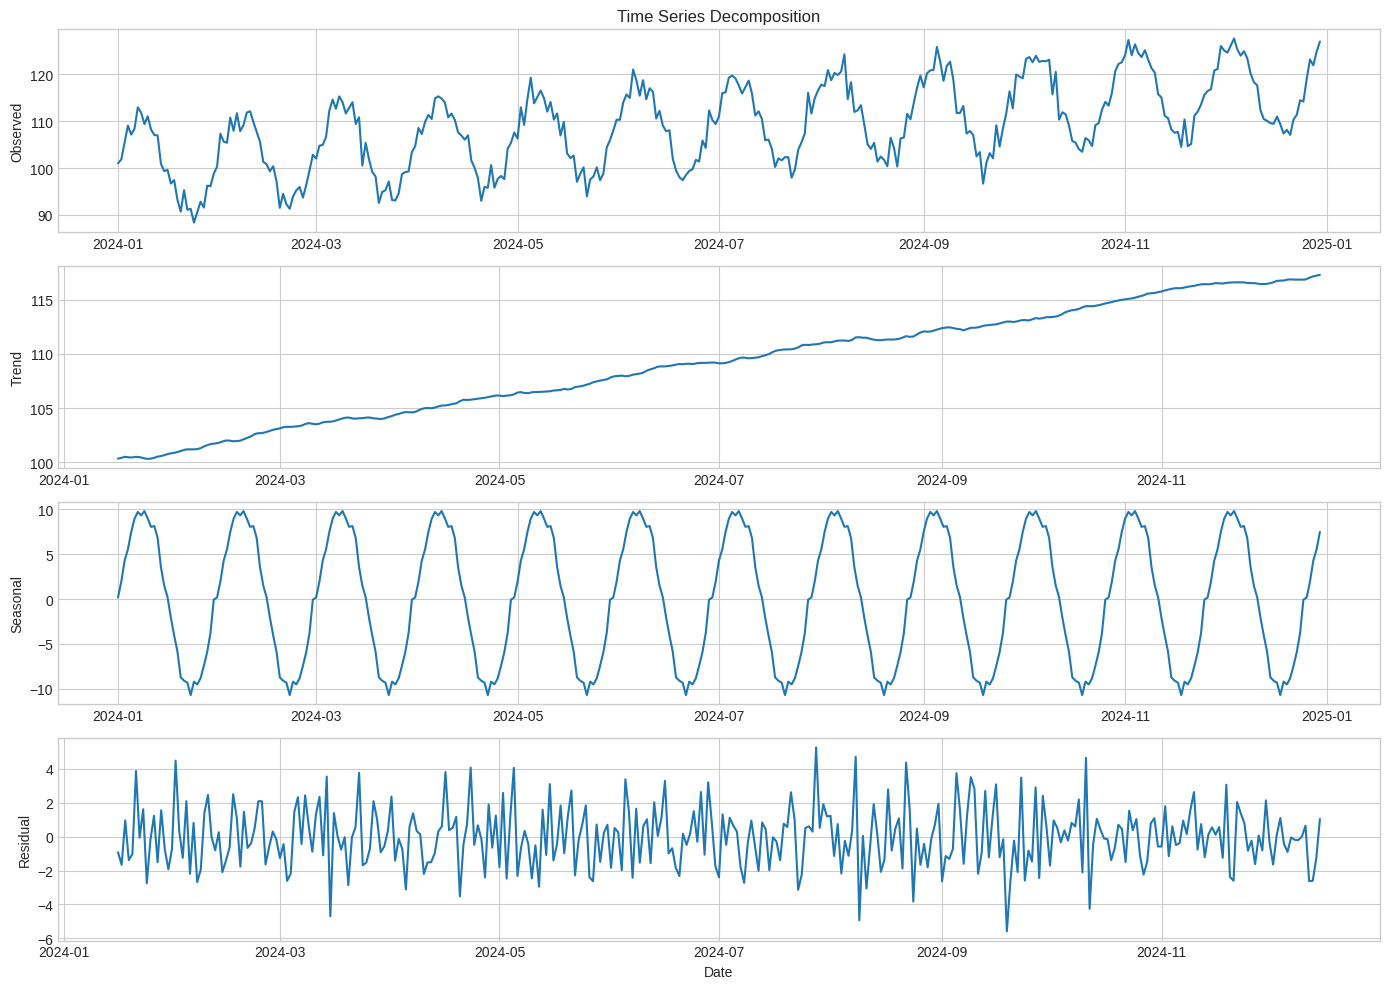

In [6]:
components = decompose_timeseries(ts, model='additive', period=30)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))

axes[0].plot(components['observed'])
axes[0].set_ylabel('Observed')
axes[0].set_title('Time Series Decomposition')

axes[1].plot(components['trend'])
axes[1].set_ylabel('Trend')

axes[2].plot(components['seasonal'])
axes[2].set_ylabel('Seasonal')

axes[3].plot(components['residual'])
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

plt.tight_layout()
plt.show()

---

## 3. Stationarity

**Stationarity** means statistical properties (mean, variance, autocorrelation) don't change over time. Most forecasting models require stationary data.

**Types of Stationarity:**
- **Strict stationarity**: Full probability distribution is time-invariant
- **Weak stationarity**: Mean and autocovariance are time-invariant

**Common Tests:**

| Test | Null Hypothesis | Reject if |
|------|-----------------|----------|
| ADF (Augmented Dickey-Fuller) | Has unit root (non-stationary) | p < 0.05 |
| KPSS | Is stationary | p < 0.05 |

**Making Data Stationary:**
- Differencing (remove trend)
- Seasonal differencing (remove seasonality)
- Log transformation (stabilise variance)

In [7]:
def test_stationarity(
    ts: pd.Series,
    significance: float = 0.05
) -> Dict[str, Any]:
    """Test for stationarity using ADF and KPSS tests.
    
    Args:
        ts: Time series data.
        significance: Significance level for tests.
    
    Returns:
        Dictionary with test results.
    """
    ts_clean = ts.dropna()
    
    adf_result = adfuller(ts_clean, autolag='AIC')
    kpss_result = kpss(ts_clean, regression='c', nlags='auto')
    
    return {
        'adf_statistic': adf_result[0],
        'adf_pvalue': adf_result[1],
        'adf_stationary': adf_result[1] < significance,
        'kpss_statistic': kpss_result[0],
        'kpss_pvalue': kpss_result[1],
        'kpss_stationary': kpss_result[1] >= significance,
        'is_stationary': (adf_result[1] < significance) and (kpss_result[1] >= significance)
    }

In [8]:
results = test_stationarity(ts)

print("Stationarity Test Results:")
print(f"\nADF Test:")
print(f"  Statistic: {results['adf_statistic']:.4f}")
print(f"  P-value: {results['adf_pvalue']:.4f}")
print(f"  Stationary (ADF): {results['adf_stationary']}")

print(f"\nKPSS Test:")
print(f"  Statistic: {results['kpss_statistic']:.4f}")
print(f"  P-value: {results['kpss_pvalue']:.4f}")
print(f"  Stationary (KPSS): {results['kpss_stationary']}")

print(f"\nOverall: {'Stationary' if results['is_stationary'] else 'Non-stationary'}")

Stationarity Test Results:

ADF Test:
  Statistic: -0.8196
  P-value: 0.8133
  Stationary (ADF): False

KPSS Test:
  Statistic: 1.4757
  P-value: 0.0100
  Stationary (KPSS): False

Overall: Non-stationary


### Differencing to Achieve Stationarity

In [9]:
def make_stationary(
    ts: pd.Series,
    max_diff: int = 2
) -> Tuple[pd.Series, int]:
    """Apply differencing to make series stationary.
    
    Args:
        ts: Time series data.
        max_diff: Maximum number of differences to try.
    
    Returns:
        Tuple of (stationary series, number of differences applied).
    """
    diff_order = 0
    ts_diff = ts.copy()
    
    for d in range(max_diff + 1):
        results = test_stationarity(ts_diff)
        if results['adf_stationary']:
            diff_order = d
            break
        ts_diff = ts_diff.diff().dropna()
        diff_order = d + 1
    
    return ts_diff, diff_order

In [10]:
ts_stationary, d = make_stationary(ts)
print(f"Differences needed: {d}")

results_after = test_stationarity(ts_stationary)
print(f"Stationary after differencing: {results_after['adf_stationary']}")

Differences needed: 1
Stationary after differencing: True


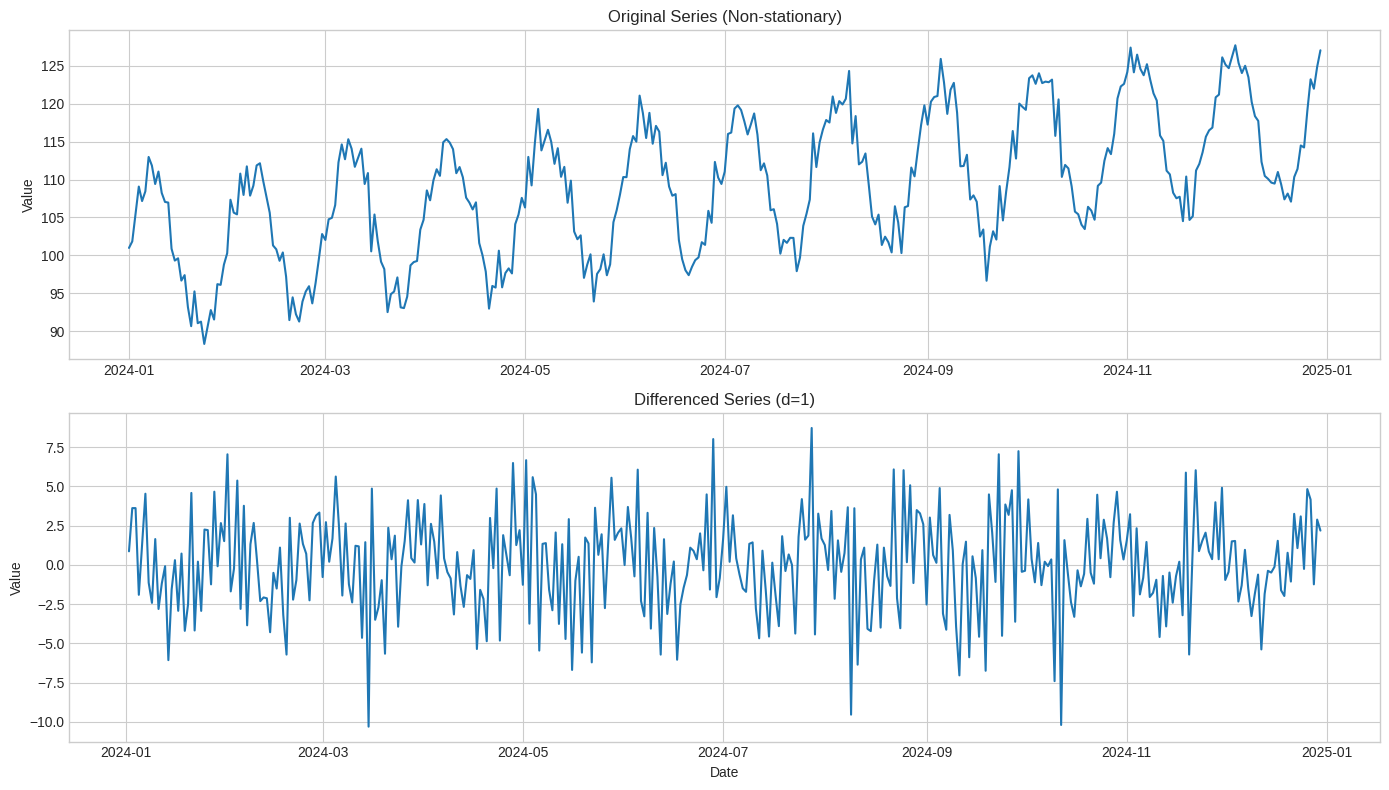

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(ts)
axes[0].set_title('Original Series (Non-stationary)')
axes[0].set_ylabel('Value')

axes[1].plot(ts_stationary)
axes[1].set_title(f'Differenced Series (d={d})')
axes[1].set_ylabel('Value')
axes[1].set_xlabel('Date')

plt.tight_layout()
plt.show()

---

## 4. Autocorrelation (ACF and PACF)

**Autocorrelation Function (ACF)**: Correlation between a series and its lagged values.

**Partial Autocorrelation Function (PACF)**: Correlation between a series and its lag, controlling for intermediate lags.

**Interpreting ACF/PACF for ARIMA:**

| Pattern | ACF | PACF | Model |
|---------|-----|------|-------|
| AR(p) | Gradual decay | Cuts off at lag p | AR |
| MA(q) | Cuts off at lag q | Gradual decay | MA |
| ARMA | Gradual decay | Gradual decay | ARMA |

In [12]:
def plot_acf_pacf(
    ts: pd.Series,
    lags: int = 40
) -> None:
    """Plot ACF and PACF for a time series.
    
    Args:
        ts: Time series data.
        lags: Number of lags to display.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    plot_acf(ts.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    plot_pacf(ts.dropna(), lags=lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

ACF/PACF of original series:


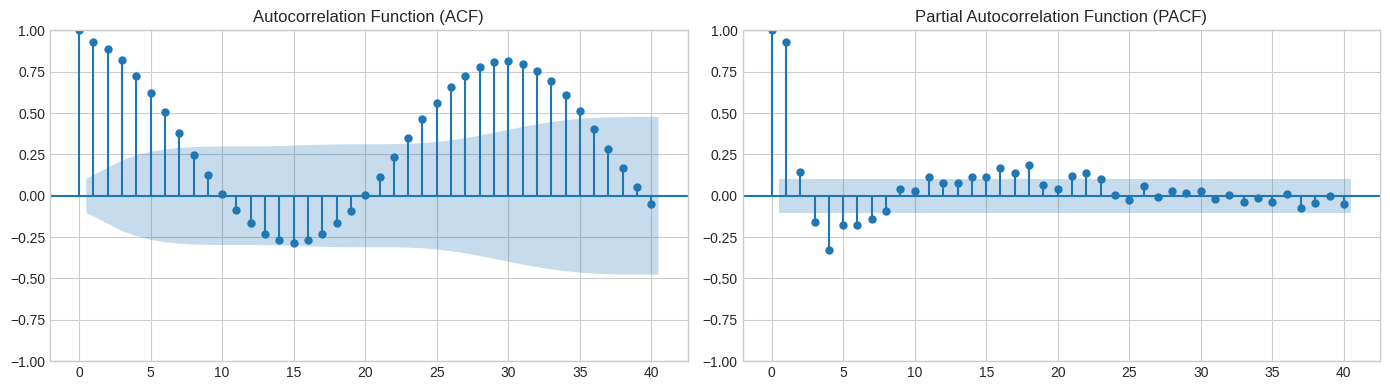


ACF/PACF of differenced series:


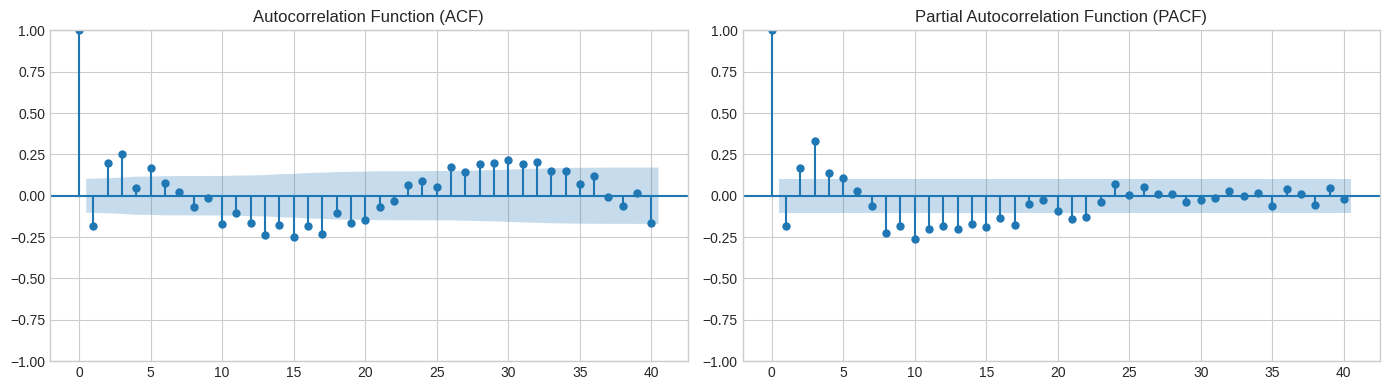

In [13]:
print("ACF/PACF of original series:")
plot_acf_pacf(ts)

print("\nACF/PACF of differenced series:")
plot_acf_pacf(ts_stationary)

In [14]:
def compute_acf_manual(
    ts: pd.Series,
    max_lag: int = 10
) -> List[float]:
    """Compute ACF manually.
    
    Args:
        ts: Time series data.
        max_lag: Maximum lag to compute.
    
    Returns:
        List of autocorrelation values.
    """
    ts_values = ts.dropna().values
    n = len(ts_values)
    mean = np.mean(ts_values)
    var = np.var(ts_values)
    
    acf_values = []
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_values.append(1.0)
        else:
            covariance = np.sum((ts_values[:-lag] - mean) * (ts_values[lag:] - mean)) / n
            acf_values.append(covariance / var)
    
    return acf_values

In [15]:
manual_acf = compute_acf_manual(ts_stationary, max_lag=10)
statsmodels_acf = acf(ts_stationary.dropna(), nlags=10)

print("ACF Comparison (first 5 lags):")
print(f"{'Lag':<5} {'Manual':<12} {'Statsmodels':<12}")
for i in range(5):
    print(f"{i:<5} {manual_acf[i]:<12.4f} {statsmodels_acf[i]:<12.4f}")

ACF Comparison (first 5 lags):
Lag   Manual       Statsmodels 
0     1.0000       1.0000      
1     -0.1819      -0.1819     
2     0.1957       0.1957      
3     0.2497       0.2497      
4     0.0439       0.0439      


---

## 5. Moving Averages and Smoothing

**Moving averages** smooth out short-term fluctuations to reveal underlying trends.

| Type | Formula | Use Case |
|------|---------|----------|
| Simple (SMA) | Unweighted mean of last n values | Trend identification |
| Weighted (WMA) | Weighted mean, recent values weighted more | Trend following |
| Exponential (EMA) | Exponentially decaying weights | Quick response to changes |

In [16]:
def compute_moving_averages(
    ts: pd.Series,
    windows: List[int] = [7, 14, 30]
) -> pd.DataFrame:
    """Compute multiple moving averages.
    
    Args:
        ts: Time series data.
        windows: List of window sizes.
    
    Returns:
        DataFrame with original and moving averages.
    """
    df = pd.DataFrame({'original': ts})
    
    for window in windows:
        df[f'SMA_{window}'] = ts.rolling(window=window).mean()
        df[f'EMA_{window}'] = ts.ewm(span=window, adjust=False).mean()
    
    return df

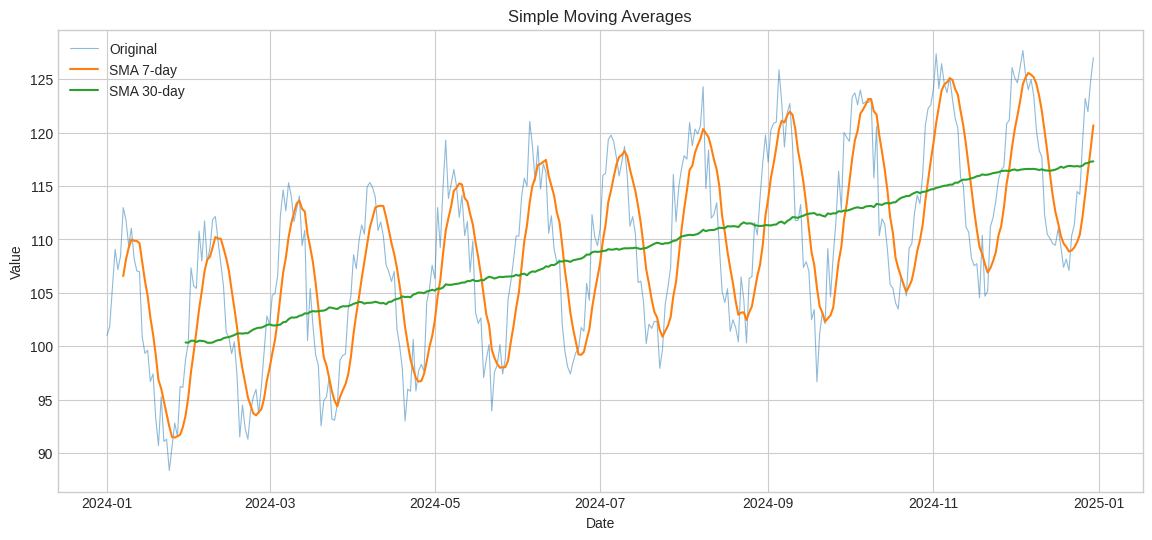

In [17]:
ma_df = compute_moving_averages(ts, windows=[7, 30])

plt.figure(figsize=(14, 6))
plt.plot(ma_df['original'], alpha=0.5, label='Original', linewidth=0.8)
plt.plot(ma_df['SMA_7'], label='SMA 7-day', linewidth=1.5)
plt.plot(ma_df['SMA_30'], label='SMA 30-day', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Simple Moving Averages')
plt.legend()
plt.show()

---

## 6. ARIMA Models

**ARIMA** (AutoRegressive Integrated Moving Average) is a popular forecasting model combining:

- **AR(p)**: Autoregressive - uses past values
- **I(d)**: Integrated - differencing for stationarity
- **MA(q)**: Moving Average - uses past forecast errors

**Model Equation:**
$$y'_t = c + \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

Where $y'_t$ is the differenced series.

**Selecting Parameters (p, d, q):**
1. **d**: Number of differences to achieve stationarity
2. **p**: PACF cutoff lag
3. **q**: ACF cutoff lag
4. **AIC/BIC**: Information criteria for model comparison

In [18]:
def fit_arima(
    ts: pd.Series,
    order: Tuple[int, int, int] = (1, 1, 1)
) -> Dict[str, Any]:
    """Fit ARIMA model.
    
    Args:
        ts: Time series data.
        order: (p, d, q) order of the model.
    
    Returns:
        Dictionary with model, summary, and diagnostics.
    """
    model = ARIMA(ts, order=order)
    fitted = model.fit()
    
    return {
        'model': fitted,
        'aic': fitted.aic,
        'bic': fitted.bic,
        'order': order,
        'residuals': fitted.resid
    }

In [19]:
arima_result = fit_arima(ts, order=(2, 1, 2))

print(f"ARIMA{arima_result['order']} Results:")
print(f"AIC: {arima_result['aic']:.2f}")
print(f"BIC: {arima_result['bic']:.2f}")
print("\nModel Summary:")
print(arima_result['model'].summary().tables[1])

ARIMA(2, 1, 2) Results:
AIC: 1774.04
BIC: 1793.52

Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2166      0.085     14.336      0.000       1.050       1.383
ar.L2         -0.3365      0.083     -4.033      0.000      -0.500      -0.173
ma.L1         -1.5303      0.052    -29.524      0.000      -1.632      -1.429
ma.L2          0.8055      0.048     16.793      0.000       0.711       0.899
sigma2         7.4204      0.540     13.748      0.000       6.363       8.478


### Grid Search for Optimal Parameters

In [20]:
def grid_search_arima(
    ts: pd.Series,
    p_range: range = range(0, 3),
    d_range: range = range(0, 2),
    q_range: range = range(0, 3)
) -> pd.DataFrame:
    """Grid search for optimal ARIMA parameters.
    
    Args:
        ts: Time series data.
        p_range: Range of p values.
        d_range: Range of d values.
        q_range: Range of q values.
    
    Returns:
        DataFrame with parameter combinations and AIC scores.
    """
    results = []
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(ts, order=(p, d, q))
                    fitted = model.fit()
                    results.append({
                        'order': (p, d, q),
                        'aic': fitted.aic,
                        'bic': fitted.bic
                    })
                except:
                    continue
    
    df = pd.DataFrame(results)
    return df.sort_values('aic').reset_index(drop=True)

In [21]:
grid_results = grid_search_arima(ts)
print("Top 5 ARIMA models by AIC:")
print(grid_results.head())

Top 5 ARIMA models by AIC:
       order          aic          bic
0  (2, 0, 2)  1733.005206  1756.404590
1  (2, 1, 2)  1774.036377  1793.522147
2  (1, 1, 2)  1784.600887  1800.189502
3  (2, 1, 1)  1820.780265  1836.368880
4  (0, 1, 2)  1833.509359  1845.200821


### Forecasting with ARIMA

In [22]:
def forecast_arima(
    ts: pd.Series,
    order: Tuple[int, int, int],
    steps: int = 30
) -> pd.DataFrame:
    """Generate forecasts with confidence intervals.
    
    Args:
        ts: Time series data.
        order: ARIMA order (p, d, q).
        steps: Number of steps to forecast.
    
    Returns:
        DataFrame with forecasts and confidence intervals.
    """
    model = ARIMA(ts, order=order)
    fitted = model.fit()
    
    forecast = fitted.get_forecast(steps=steps)
    forecast_df = pd.DataFrame({
        'forecast': forecast.predicted_mean,
        'lower_ci': forecast.conf_int().iloc[:, 0],
        'upper_ci': forecast.conf_int().iloc[:, 1]
    })
    
    return forecast_df

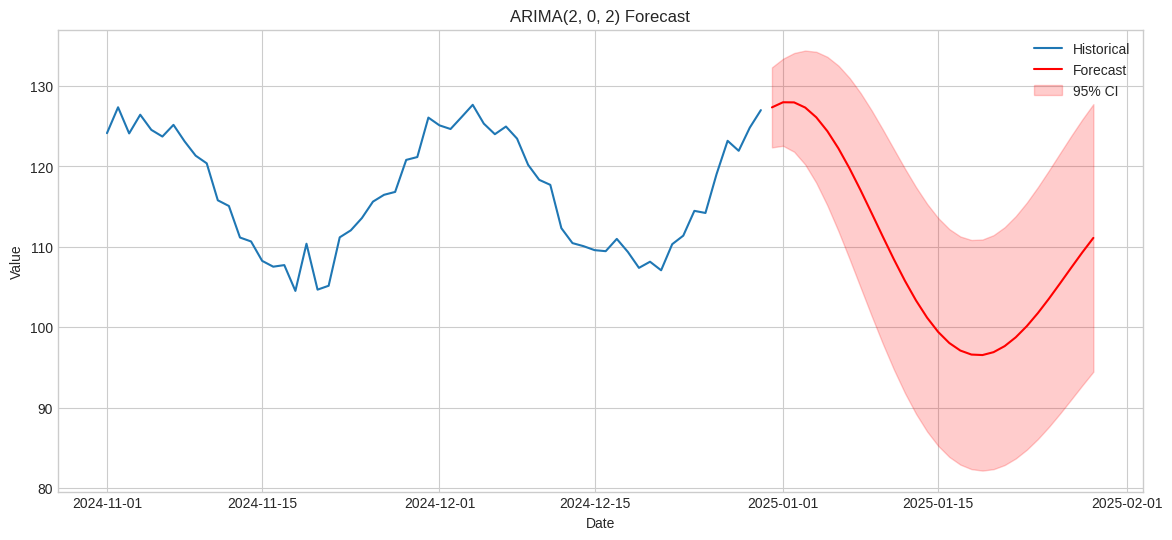

In [23]:
best_order = grid_results.iloc[0]['order']
forecast_df = forecast_arima(ts, order=best_order, steps=30)

plt.figure(figsize=(14, 6))
plt.plot(ts[-60:], label='Historical', linewidth=1.5)
plt.plot(forecast_df.index, forecast_df['forecast'], label='Forecast', color='red', linewidth=1.5)
plt.fill_between(
    forecast_df.index,
    forecast_df['lower_ci'],
    forecast_df['upper_ci'],
    color='red', alpha=0.2, label='95% CI'
)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'ARIMA{best_order} Forecast')
plt.legend()
plt.show()

---

## 7. Seasonal ARIMA (SARIMA)

**SARIMA** extends ARIMA to handle seasonality with notation: ARIMA(p,d,q)(P,D,Q)[m]

- **(p, d, q)**: Non-seasonal components
- **(P, D, Q)**: Seasonal components
- **[m]**: Seasonal period (e.g., 12 for monthly data with yearly seasonality)

In [24]:
def fit_sarima(
    ts: pd.Series,
    order: Tuple[int, int, int] = (1, 1, 1),
    seasonal_order: Tuple[int, int, int, int] = (1, 1, 1, 12)
) -> Dict[str, Any]:
    """Fit SARIMA model.
    
    Args:
        ts: Time series data.
        order: (p, d, q) non-seasonal order.
        seasonal_order: (P, D, Q, m) seasonal order.
    
    Returns:
        Dictionary with model and diagnostics.
    """
    model = SARIMAX(ts, order=order, seasonal_order=seasonal_order)
    fitted = model.fit(disp=False)
    
    return {
        'model': fitted,
        'aic': fitted.aic,
        'bic': fitted.bic,
        'order': order,
        'seasonal_order': seasonal_order
    }

In [25]:
sarima_result = fit_sarima(ts, order=(1, 1, 1), seasonal_order=(1, 0, 1, 30))

print(f"SARIMA{sarima_result['order']}x{sarima_result['seasonal_order']} Results:")
print(f"AIC: {sarima_result['aic']:.2f}")
print(f"BIC: {sarima_result['bic']:.2f}")

SARIMA(1, 1, 1)x(1, 0, 1, 30) Results:
AIC: 1672.21
BIC: 1691.70


---

## 8. Exponential Smoothing

**Exponential smoothing** methods use weighted averages of past observations, with weights decaying exponentially.

| Method | Components | Use Case |
|--------|------------|----------|
| Simple (SES) | Level only | No trend, no seasonality |
| Holt | Level + Trend | Trend, no seasonality |
| Holt-Winters | Level + Trend + Seasonal | Trend and seasonality |

In [26]:
def fit_exponential_smoothing(
    ts: pd.Series,
    trend: str = 'add',
    seasonal: str = 'add',
    seasonal_periods: int = 30
) -> Dict[str, Any]:
    """Fit Holt-Winters exponential smoothing model.
    
    Args:
        ts: Time series data.
        trend: 'add', 'mul', or None.
        seasonal: 'add', 'mul', or None.
        seasonal_periods: Number of periods in a season.
    
    Returns:
        Dictionary with model and parameters.
    """
    model = ExponentialSmoothing(
        ts,
        trend=trend,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods
    )
    fitted = model.fit()
    
    return {
        'model': fitted,
        'aic': fitted.aic,
        'alpha': fitted.params.get('smoothing_level', None),
        'beta': fitted.params.get('smoothing_trend', None),
        'gamma': fitted.params.get('smoothing_seasonal', None)
    }

In [27]:
hw_result = fit_exponential_smoothing(ts, trend='add', seasonal='add', seasonal_periods=30)

print("Holt-Winters Parameters:")
print(f"Alpha (level): {hw_result['alpha']:.4f}")
print(f"Beta (trend): {hw_result['beta']:.4f}")
print(f"Gamma (seasonal): {hw_result['gamma']:.4f}")
print(f"AIC: {hw_result['aic']:.2f}")

Holt-Winters Parameters:
Alpha (level): 0.0000
Beta (trend): 0.0000
Gamma (seasonal): 0.0000
AIC: 499.30


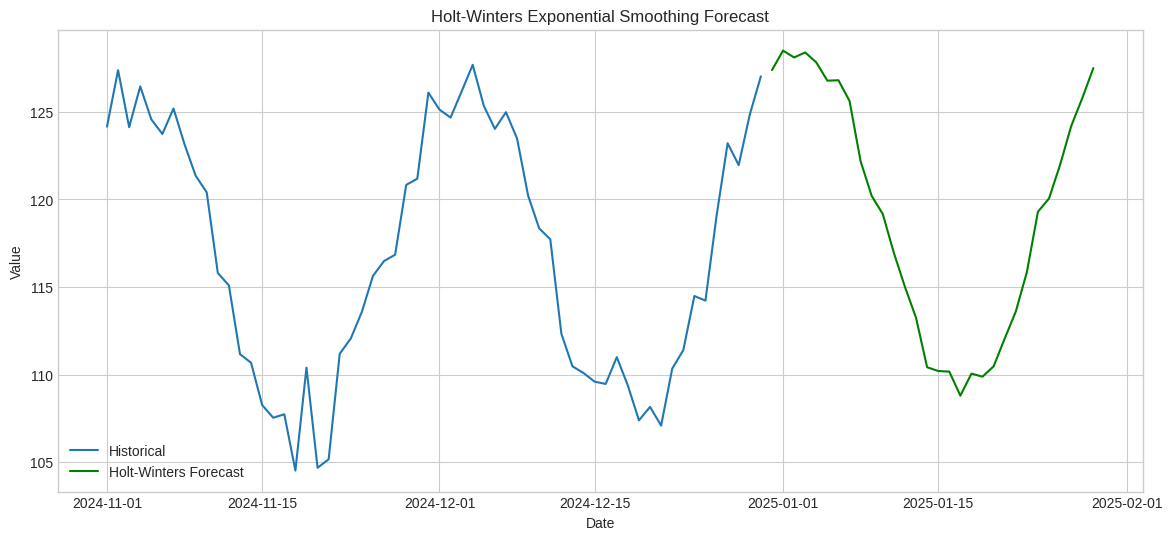

In [28]:
hw_forecast = hw_result['model'].forecast(steps=30)

plt.figure(figsize=(14, 6))
plt.plot(ts[-60:], label='Historical', linewidth=1.5)
plt.plot(hw_forecast.index, hw_forecast.values, label='Holt-Winters Forecast', 
         color='green', linewidth=1.5)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.legend()
plt.show()

---

## 9. Time Series Cross-Validation

**Standard cross-validation doesn't work** for time series because:
- Data is temporally ordered
- Cannot use future data to predict past

**Walk-Forward Validation:**
1. Train on observations 1 to t
2. Forecast observation t+1
3. Expand training window and repeat

In [29]:
def time_series_cv(
    ts: pd.Series,
    model_func,
    initial_train_size: int = 200,
    horizon: int = 1,
    step: int = 1
) -> Dict[str, Any]:
    """Perform walk-forward cross-validation.
    
    Args:
        ts: Time series data.
        model_func: Function that fits model and returns forecast.
        initial_train_size: Initial training window size.
        horizon: Forecast horizon.
        step: Step size between windows.
    
    Returns:
        Dictionary with predictions, actuals, and metrics.
    """
    predictions = []
    actuals = []
    
    for i in range(initial_train_size, len(ts) - horizon + 1, step):
        train = ts[:i]
        test = ts[i:i + horizon]
        
        pred = model_func(train, horizon)
        
        predictions.extend(pred.values)
        actuals.extend(test.values)
    
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mape = np.mean(np.abs((np.array(actuals) - np.array(predictions)) / np.array(actuals))) * 100
    
    return {
        'predictions': predictions,
        'actuals': actuals,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }

In [30]:
def arima_forecast_func(train: pd.Series, horizon: int) -> pd.Series:
    """Helper function for ARIMA forecasting in CV."""
    model = ARIMA(train, order=(1, 1, 1))
    fitted = model.fit()
    return fitted.forecast(steps=horizon)


cv_results = time_series_cv(ts, arima_forecast_func, initial_train_size=300, horizon=1, step=5)

print("Cross-Validation Results:")
print(f"MAE: {cv_results['mae']:.4f}")
print(f"RMSE: {cv_results['rmse']:.4f}")
print(f"MAPE: {cv_results['mape']:.2f}%")

Cross-Validation Results:
MAE: 1.5514
RMSE: 2.1072
MAPE: 1.33%


---

## 10. Forecasting Metrics

| Metric | Formula | Interpretation |
|--------|---------|----------------|
| MAE | $\frac{1}{n}\sum|y_i - \hat{y}_i|$ | Average absolute error |
| MSE | $\frac{1}{n}\sum(y_i - \hat{y}_i)^2$ | Penalises large errors |
| RMSE | $\sqrt{MSE}$ | Same units as data |
| MAPE | $\frac{100}{n}\sum|\frac{y_i - \hat{y}_i}{y_i}|$ | Percentage error |
| SMAPE | $\frac{100}{n}\sum\frac{2|y_i - \hat{y}_i|}{|y_i| + |\hat{y}_i|}$ | Symmetric percentage |

In [31]:
def calculate_forecast_metrics(
    actual: np.ndarray,
    predicted: np.ndarray
) -> Dict[str, float]:
    """Calculate common forecasting metrics.
    
    Args:
        actual: Actual values.
        predicted: Predicted values.
    
    Returns:
        Dictionary of metrics.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    mae = np.mean(np.abs(actual - predicted))
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    
    non_zero_mask = actual != 0
    mape = np.mean(np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / actual[non_zero_mask])) * 100
    
    smape = np.mean(2 * np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))) * 100
    
    return {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'SMAPE': smape
    }

In [32]:
metrics = calculate_forecast_metrics(cv_results['actuals'], cv_results['predictions'])

print("Forecast Metrics:")
for metric, value in metrics.items():
    print(f"  {metric}: {value:.4f}")

Forecast Metrics:
  MAE: 1.5514
  MSE: 4.4403
  RMSE: 2.1072
  MAPE: 1.3281
  SMAPE: 1.3261


---

## 11. Feature Engineering for Time Series

For machine learning approaches, you need to create features from the time series.

In [33]:
def create_ts_features(ts: pd.Series, lags: int = 7) -> pd.DataFrame:
    """Create time series features for ML models.
    
    Args:
        ts: Time series data with datetime index.
        lags: Number of lag features.
    
    Returns:
        DataFrame with engineered features.
    """
    df = pd.DataFrame(index=ts.index)
    df['value'] = ts.values
    
    # Lag features
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = ts.shift(lag).values
    
    # Rolling statistics
    df['rolling_mean_7'] = ts.rolling(window=7).mean().values
    df['rolling_std_7'] = ts.rolling(window=7).std().values
    df['rolling_mean_30'] = ts.rolling(window=30).mean().values
    
    # Date features
    df['day_of_week'] = ts.index.dayofweek
    df['day_of_month'] = ts.index.day
    df['month'] = ts.index.month
    df['is_weekend'] = (ts.index.dayofweek >= 5).astype(int)
    
    # Difference features
    df['diff_1'] = ts.diff(1).values
    df['diff_7'] = ts.diff(7).values
    
    return df

In [34]:
features_df = create_ts_features(ts, lags=7)
print(f"Created {len(features_df.columns)} features:")
print(features_df.columns.tolist())
print("\nSample:")
print(features_df.dropna().head())

Created 17 features:
['value', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_30', 'day_of_week', 'day_of_month', 'month', 'is_weekend', 'diff_1', 'diff_7']

Sample:
                 value       lag_1       lag_2       lag_3      lag_4  \
2024-01-30   98.787496   96.131356   96.223544   91.566565  92.811591   
2024-01-31  100.296587   98.787496   96.131356   96.223544  91.566565   
2024-02-01  107.333673  100.296587   98.787496   96.131356  96.223544   
2024-02-02  105.640372  107.333673  100.296587   98.787496  96.131356   
2024-02-03  105.412431  105.640372  107.333673  100.296587  98.787496   

                lag_5      lag_6      lag_7  rolling_mean_7  rolling_std_7  \
2024-01-30  90.600669  88.355285  91.289837       93.496644       3.682969   
2024-01-31  92.811591  90.600669  88.355285       95.202544       3.670162   
2024-02-01  91.566565  92.811591  90.600669       97.592973       5.272705   
2024-02-02  96.223

## 12. Practice Questions

Test your understanding with these interview-style questions. Try to solve each question in the empty code cell before revealing the answer.

### Question 1: Stationarity Test from Scratch

Implement a simplified version of the rolling statistics test for stationarity.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd

def rolling_stationarity_test(
    ts: pd.Series,
    window: int = 50,
    threshold: float = 0.1
) -> dict:
    """Test stationarity using rolling mean and std.
    
    Args:
        ts: Time series data.
        window: Rolling window size.
        threshold: Variation threshold for stationarity.
    
    Returns:
        Dictionary with test results.
    """
    rolling_mean = ts.rolling(window=window).mean()
    rolling_std = ts.rolling(window=window).std()
    
    # Check if rolling statistics are stable
    mean_variation = rolling_mean.std() / rolling_mean.mean()
    std_variation = rolling_std.std() / rolling_std.mean()
    
    is_stationary = (mean_variation < threshold) and (std_variation < threshold)
    
    return {
        'mean_variation': mean_variation,
        'std_variation': std_variation,
        'is_stationary': is_stationary
    }


# Test
ts = create_sample_timeseries()
result = rolling_stationarity_test(ts)
print(f"Mean variation: {result['mean_variation']:.4f}")
print(f"Std variation: {result['std_variation']:.4f}")
print(f"Stationary: {result['is_stationary']}")
```

</details>


---

### Question 2: Simple Moving Average Forecast

Implement a simple moving average forecasting function.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd

def sma_forecast(
    ts: pd.Series,
    window: int = 7,
    steps: int = 5
) -> pd.Series:
    """Forecast using simple moving average.
    
    Args:
        ts: Time series data.
        window: Window size for moving average.
        steps: Number of steps to forecast.
    
    Returns:
        Series of forecasted values.
    """
    values = ts.values.tolist()
    forecasts = []
    
    for _ in range(steps):
        forecast = np.mean(values[-window:])
        forecasts.append(forecast)
        values.append(forecast)
    
    # Create index for forecasts
    last_date = ts.index[-1]
    freq = pd.infer_freq(ts.index)
    forecast_index = pd.date_range(start=last_date, periods=steps + 1, freq=freq)[1:]
    
    return pd.Series(forecasts, index=forecast_index)


# Test
ts = create_sample_timeseries()
forecast = sma_forecast(ts, window=7, steps=5)
print("SMA Forecast:")
print(forecast)
```

</details>


---

### Question 3: ACF from Scratch

Implement autocorrelation function calculation without using statsmodels.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
from typing import List

def acf_from_scratch(
    ts: np.ndarray,
    max_lag: int = 20
) -> List[float]:
    """Calculate ACF from scratch.
    
    Args:
        ts: Time series values.
        max_lag: Maximum lag to calculate.
    
    Returns:
        List of autocorrelation values.
    """
    n = len(ts)
    mean = np.mean(ts)
    variance = np.sum((ts - mean) ** 2) / n
    
    acf_values = []
    
    for lag in range(max_lag + 1):
        if lag == 0:
            acf_values.append(1.0)
        else:
            covariance = np.sum((ts[:-lag] - mean) * (ts[lag:] - mean)) / n
            acf_values.append(covariance / variance)
    
    return acf_values


# Test
ts = create_sample_timeseries()
acf_vals = acf_from_scratch(ts.values, max_lag=10)
print("ACF values:")
for i, val in enumerate(acf_vals[:5]):
    print(f"  Lag {i}: {val:.4f}")
```

</details>


---

### Question 4: Exponential Smoothing from Scratch

Implement simple exponential smoothing.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
from typing import Tuple

def simple_exponential_smoothing(
    ts: np.ndarray,
    alpha: float = 0.3,
    forecast_steps: int = 5
) -> Tuple[np.ndarray, np.ndarray]:
    """Simple exponential smoothing from scratch.
    
    Args:
        ts: Time series values.
        alpha: Smoothing parameter (0 < alpha < 1).
        forecast_steps: Number of steps to forecast.
    
    Returns:
        Tuple of (smoothed values, forecasts).
    """
    n = len(ts)
    smoothed = np.zeros(n)
    
    # Initialise with first value
    smoothed[0] = ts[0]
    
    # Apply smoothing
    for t in range(1, n):
        smoothed[t] = alpha * ts[t] + (1 - alpha) * smoothed[t-1]
    
    # Forecast (flat for SES)
    forecasts = np.full(forecast_steps, smoothed[-1])
    
    return smoothed, forecasts


# Test
ts = create_sample_timeseries()
smoothed, forecast = simple_exponential_smoothing(ts.values, alpha=0.3, forecast_steps=5)
print(f"Last smoothed value: {smoothed[-1]:.2f}")
print(f"Forecast: {forecast}")
```

</details>


---

### Question 5: Seasonal Differencing

Implement a function that applies seasonal differencing.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import pandas as pd

def seasonal_difference(
    ts: pd.Series,
    period: int = 12,
    order: int = 1
) -> pd.Series:
    """Apply seasonal differencing.
    
    Args:
        ts: Time series data.
        period: Seasonal period.
        order: Number of times to difference.
    
    Returns:
        Seasonally differenced series.
    """
    result = ts.copy()
    
    for _ in range(order):
        result = result - result.shift(period)
    
    return result.dropna()


# Test
ts = create_sample_timeseries(seasonality_period=30)
ts_diff = seasonal_difference(ts, period=30)
print(f"Original length: {len(ts)}")
print(f"After seasonal diff: {len(ts_diff)}")
```

</details>


---

### Question 6: MAPE Calculation

Implement MAPE with handling for zero values.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
from typing import Optional

def calculate_mape(
    actual: np.ndarray,
    predicted: np.ndarray,
    epsilon: float = 1e-10
) -> Optional[float]:
    """Calculate MAPE with zero handling.
    
    Args:
        actual: Actual values.
        predicted: Predicted values.
        epsilon: Small value to avoid division by zero.
    
    Returns:
        MAPE value as percentage, or None if cannot calculate.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Mask for non-zero actual values
    non_zero_mask = np.abs(actual) > epsilon
    
    if not np.any(non_zero_mask):
        return None
    
    mape = np.mean(
        np.abs((actual[non_zero_mask] - predicted[non_zero_mask]) / 
               actual[non_zero_mask])
    ) * 100
    
    return mape


# Test
actual = np.array([100, 150, 0, 200, 180])
predicted = np.array([110, 140, 10, 190, 175])
mape = calculate_mape(actual, predicted)
print(f"MAPE: {mape:.2f}%")
```

</details>


---

### Question 7: Walk-Forward Validation

Implement walk-forward validation with expanding window.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd
from typing import Callable, Dict, List

def walk_forward_validation(
    ts: pd.Series,
    model_func: Callable,
    min_train: int = 100,
    horizon: int = 1
) -> Dict[str, List]:
    """Walk-forward validation with expanding window.
    
    Args:
        ts: Time series data.
        model_func: Function(train, horizon) -> predictions.
        min_train: Minimum training size.
        horizon: Forecast horizon.
    
    Returns:
        Dictionary with predictions and actuals.
    """
    predictions = []
    actuals = []
    
    for i in range(min_train, len(ts) - horizon + 1):
        train = ts[:i]
        test = ts[i:i + horizon]
        
        pred = model_func(train, horizon)
        
        predictions.extend(pred if hasattr(pred, '__iter__') else [pred])
        actuals.extend(test.values)
    
    return {
        'predictions': predictions,
        'actuals': actuals
    }


# Test
def naive_forecast(train, horizon):
    return [train.iloc[-1]] * horizon

ts = create_sample_timeseries(n_points=150)
results = walk_forward_validation(ts, naive_forecast, min_train=100)
print(f"Predictions: {len(results['predictions'])}")
print(f"MAE: {np.mean(np.abs(np.array(results['actuals']) - np.array(results['predictions']))):.4f}")
```

</details>


---

### Question 8: Lag Features

Create a function that generates lag features for ML models.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import pandas as pd
from typing import List

def create_lag_features(
    ts: pd.Series,
    target_col: str = 'target',
    lags: List[int] = [1, 2, 3, 7, 14]
) -> pd.DataFrame:
    """Create lag features for supervised learning.
    
    Args:
        ts: Time series data.
        target_col: Name for target column.
        lags: List of lag values.
    
    Returns:
        DataFrame with lag features.
    """
    df = pd.DataFrame(index=ts.index)
    df[target_col] = ts.values
    
    for lag in lags:
        df[f'lag_{lag}'] = ts.shift(lag).values
    
    return df.dropna()


# Test
ts = create_sample_timeseries()
features = create_lag_features(ts, lags=[1, 7, 30])
print("Features shape:", features.shape)
print(features.head())
```

</details>


---

### Question 9: Trend Removal

Implement trend removal using linear regression.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd
from typing import Tuple

def remove_trend(
    ts: pd.Series
) -> Tuple[pd.Series, float, float]:
    """Remove linear trend from time series.
    
    Args:
        ts: Time series data.
    
    Returns:
        Tuple of (detrended series, slope, intercept).
    """
    t = np.arange(len(ts))
    
    # Fit linear trend
    slope, intercept = np.polyfit(t, ts.values, 1)
    
    # Remove trend
    trend = slope * t + intercept
    detrended = pd.Series(ts.values - trend, index=ts.index)
    
    return detrended, slope, intercept


# Test
ts = create_sample_timeseries(trend=0.1)
detrended, slope, intercept = remove_trend(ts)
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.4f}")
print(f"Original mean: {ts.mean():.2f}")
print(f"Detrended mean: {detrended.mean():.2f}")
```

</details>


---

### Question 10: Naive Forecasting Methods

Implement multiple naive forecasting baselines.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd
from typing import Dict

def naive_forecasts(
    ts: pd.Series,
    steps: int = 5,
    seasonal_period: int = 7
) -> Dict[str, np.ndarray]:
    """Generate multiple naive forecasts.
    
    Args:
        ts: Time series data.
        steps: Forecast horizon.
        seasonal_period: Period for seasonal naive.
    
    Returns:
        Dictionary of forecast arrays.
    """
    forecasts = {}
    
    # Last value (naive)
    forecasts['naive'] = np.full(steps, ts.iloc[-1])
    
    # Mean
    forecasts['mean'] = np.full(steps, ts.mean())
    
    # Drift (last value + average change)
    avg_change = (ts.iloc[-1] - ts.iloc[0]) / (len(ts) - 1)
    forecasts['drift'] = ts.iloc[-1] + avg_change * np.arange(1, steps + 1)
    
    # Seasonal naive
    seasonal_forecasts = []
    for i in range(steps):
        idx = -(seasonal_period - (i % seasonal_period))
        seasonal_forecasts.append(ts.iloc[idx])
    forecasts['seasonal_naive'] = np.array(seasonal_forecasts)
    
    return forecasts


# Test
ts = create_sample_timeseries()
forecasts = naive_forecasts(ts, steps=5, seasonal_period=30)
for method, values in forecasts.items():
    print(f"{method}: {values}")
```

</details>


---

### Question 11: Detect Seasonality Period

Implement a function to detect the dominant seasonal period.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd

def detect_seasonality(
    ts: pd.Series,
    max_period: int = 60
) -> int:
    """Detect dominant seasonal period using ACF.
    
    Args:
        ts: Time series data.
        max_period: Maximum period to check.
    
    Returns:
        Detected seasonal period.
    """
    from statsmodels.tsa.stattools import acf
    
    # Compute ACF
    acf_values = acf(ts.dropna(), nlags=max_period)
    
    # Find peaks (local maxima) excluding lag 0
    peaks = []
    for i in range(2, len(acf_values) - 1):
        if acf_values[i] > acf_values[i-1] and acf_values[i] > acf_values[i+1]:
            peaks.append((i, acf_values[i]))
    
    if not peaks:
        return 1  # No seasonality detected
    
    # Return lag with highest ACF peak
    dominant_period = max(peaks, key=lambda x: x[1])[0]
    
    return dominant_period


# Test
ts = create_sample_timeseries(seasonality_period=30)
period = detect_seasonality(ts)
print(f"Detected seasonal period: {period}")
```

</details>


---

### Question 12: Model Comparison

Compare multiple forecasting models and return the best one.

In [ ]:
# Write your solution here

<details>
<summary>Click to reveal answer</summary>

```python
import numpy as np
import pandas as pd
from typing import Dict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def compare_models(
    ts: pd.Series,
    test_size: int = 30
) -> Dict[str, Dict]:
    """Compare forecasting models on held-out test set.
    
    Args:
        ts: Time series data.
        test_size: Size of test set.
    
    Returns:
        Dictionary with model results.
    """
    train = ts[:-test_size]
    test = ts[-test_size:]
    
    results = {}
    
    # Naive
    naive_pred = np.full(test_size, train.iloc[-1])
    results['Naive'] = {
        'predictions': naive_pred,
        'rmse': np.sqrt(np.mean((test.values - naive_pred) ** 2))
    }
    
    # ARIMA
    try:
        arima = ARIMA(train, order=(1, 1, 1)).fit()
        arima_pred = arima.forecast(steps=test_size)
        results['ARIMA(1,1,1)'] = {
            'predictions': arima_pred.values,
            'rmse': np.sqrt(np.mean((test.values - arima_pred.values) ** 2))
        }
    except:
        pass
    
    # Exponential Smoothing
    try:
        hw = ExponentialSmoothing(train, trend='add').fit()
        hw_pred = hw.forecast(steps=test_size)
        results['ExpSmoothing'] = {
            'predictions': hw_pred.values,
            'rmse': np.sqrt(np.mean((test.values - hw_pred.values) ** 2))
        }
    except:
        pass
    
    # Find best model
    best_model = min(results.items(), key=lambda x: x[1]['rmse'])
    
    return {
        'all_results': results,
        'best_model': best_model[0],
        'best_rmse': best_model[1]['rmse']
    }


# Test
ts = create_sample_timeseries()
comparison = compare_models(ts, test_size=30)
print("Model Comparison:")
for model, data in comparison['all_results'].items():
    print(f"  {model}: RMSE = {data['rmse']:.4f}")
print(f"\nBest model: {comparison['best_model']}")
```

</details>


---

## 13. Summary

This notebook covered essential time series concepts:

1. **Components**: Trend, seasonality, cyclical patterns, and residuals
2. **Stationarity**: ADF and KPSS tests, differencing to achieve stationarity
3. **ACF/PACF**: Understanding autocorrelation for model selection
4. **Moving Averages**: Simple, weighted, and exponential smoothing
5. **ARIMA**: Autoregressive integrated moving average models
6. **SARIMA**: Handling seasonality in ARIMA
7. **Exponential Smoothing**: Holt-Winters method
8. **Cross-Validation**: Walk-forward validation for time series
9. **Metrics**: MAE, RMSE, MAPE, SMAPE
10. **Feature Engineering**: Lag features, rolling statistics, date features

---

### Key Interview Tips

- **Always check stationarity first**: Most models require stationary data
- **Use appropriate CV**: Never use random splits for time series
- **Start with baselines**: Naive methods set the performance floor
- **Understand ACF/PACF**: They guide ARIMA parameter selection
- **Know the metrics**: MAPE is intuitive but fails with zeros; use SMAPE or RMSE
- **Feature engineering matters**: Lag features make time series work with ML models